# Intuitions on State Space Model

In this notebook, we will play around with the parameters of a state space model and generate various spike trains.
These population activity patterns will be fun to look at. (hopefully)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## A simple 1-D latent process

For illustration, we will use a sinusoid as the 1-D latent process.
$$ x(t) = sin(2\pi f\cdot t) $$
In this example, $x(t)$ represents the instantaneous state of the neural population of interest.

In [2]:
# simulate a simple latent process
nT = 1000
T = 10
frq = 0.3
tr = np.linspace(0, T, nT)
dt = tr[1] - tr[0]
x = np.sin(2 * np.pi * frq * tr) # generate a sinusoid over time

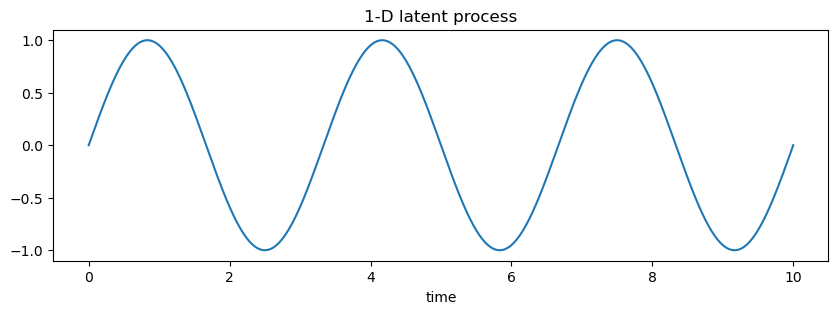

In [3]:
fig = plt.figure(figsize=(10, 3))
plt.plot(tr, x); plt.title('1-D latent process'); plt.xlabel('time');

## One Poisson neuron driven by the latent process

We will generate spike trains from an inhomogeneous Poisson process with a time varying firing rate function $\lambda(t)$.
The spike count $y(t)$ in a small time bin of size $\Delta$ is distributed as a Poisson distribution:
$$ y(t) \sim \text{Poisson}(\Delta\lambda(t)) $$

Importantly, the firing rate will be a function of $x(t)$, but not of past $x$ nor past $y$.
$$ \lambda(t) = g(x(t)) $$
The only constraint is that the firing rate has to be non-negative.
A mathematically convenient function is the exponential function.

$$ \lambda(t) = \exp(a x(t) + b) = \exp(b)\exp(a x(t)) $$

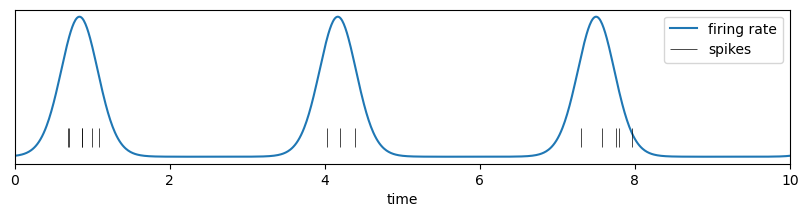

In [4]:
a = 5
b = -3
lam = np.exp(a * x + b)
y = np.random.poisson(lam*dt)

plt.figure(figsize=(10, 2))
plt.plot(tr, lam, label='firing rate');
plt.eventplot(np.nonzero(y)[0]/nT*T, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.legend();

## A population of Poisson neurons driven by a common 1-D latent process

TODO: explain linear dimensionality expansion in the observation model

In [5]:
nNeuron = 200
C = 2 * np.random.randn(nNeuron)
cidx = np.argsort(C)
b = -2.0 + np.random.rand(nNeuron,1)
lam = np.exp(np.outer(C, x) + b)
y = np.random.poisson(lam*dt)

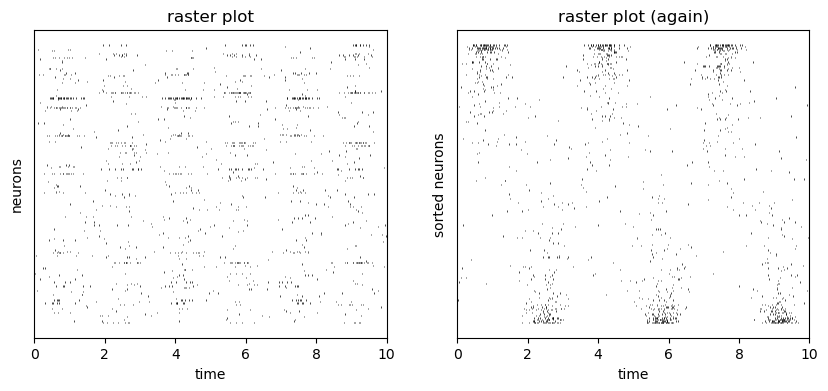

In [6]:
raster = []
rasterSorted = []
for k in range(nNeuron):
    raster.append(np.nonzero(y[k,:])[0]/nT*T)
    rasterSorted.append(np.nonzero(y[cidx[k],:])[0]/nT*T)

plt.subplots(1,2, figsize=(10, 4))
plt.subplot(1,2,1)
plt.eventplot(raster, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.title('raster plot'); plt.ylabel('neurons');
plt.subplot(1,2,2)
plt.eventplot(rasterSorted, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.title('raster plot (again)'); plt.ylabel('sorted neurons');

## 2D latent space example

Here we will build a 2D manifold with two independent processes.
The first latent dimension will be same as above, but we will add $x_2(t)$ as a sawtooth function:
$$ x_2(t) = t \,\, \text{mod} \, 1 $$

In [8]:
x2 = 1.5 * ((tr % 1) - 0.5)
X = np.vstack([x, x2]) # (latent dim) x (time)

Text(0.5, 0, 'time')

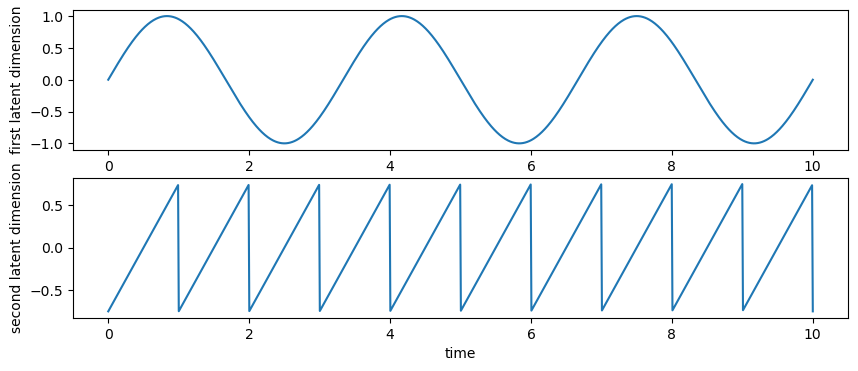

In [9]:
plt.subplots(2,1,figsize=(10,4))
plt.subplot(2,1,1);
plt.plot(tr, x ); plt.ylabel('first latent dimension'); plt.xlabel('time')
plt.subplot(2,1,2);
plt.plot(tr, x2); plt.ylabel('second latent dimension'); plt.xlabel('time')

### Random projection observation

The neural manifold is likely oblique.
[Gao & Ganguli 2015] assumes this.

- Gao, P., & Ganguli, S. (2015). On Simplicity and Complexity in the Brave New World of Large-Scale Neuroscience. Current Opinion in Neurobiology, 32, 148–155.

In [10]:
dLatent = X.shape[0]
C = 2 * np.random.randn(nNeuron, dLatent)
lam = np.exp(C @ X + b)
y = np.random.poisson(lam*dt)

In [11]:
cidx1 = np.lexsort((C[:,0], C[:,1]), axis=0)
cidx2 = np.lexsort((C[:,1], C[:,0]), axis=0)

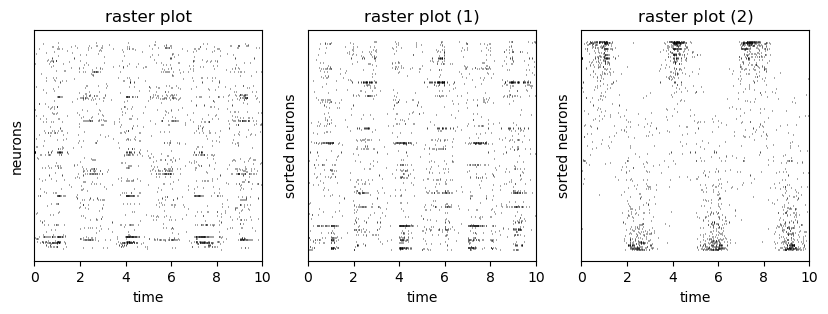

In [12]:
raster = []; rasterSorted1 = []; rasterSorted2 = []
for k in range(nNeuron):
    raster.append(np.nonzero(y[k,:])[0]/nT*T)
    rasterSorted1.append(np.nonzero(y[cidx1[k],:])[0]/nT*T)
    rasterSorted2.append(np.nonzero(y[cidx2[k],:])[0]/nT*T)

plt.subplots(1,3, figsize=(10, 3))
plt.subplot(1,3,1)
plt.eventplot(raster, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.title('raster plot'); plt.ylabel('neurons');
plt.subplot(1,3,2)
plt.eventplot(rasterSorted1, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.title('raster plot (1)'); plt.ylabel('sorted neurons');
plt.subplot(1,3,3)
plt.eventplot(rasterSorted2, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.title('raster plot (2)'); plt.ylabel('sorted neurons');

### Axis aligned observation

Biologists have long loved neurons that are tuned specifically for a particular feature but not modulated by others.
In our context, the neurons will be either driven by the first dimension or the second dimension of the latent process.
Recent paper argues that this is optimal [Whittington et al. 2022].

 - Whittington, J. C. R., Dorrell, W., Ganguli, S., & Behrens, T. E. J. (2022). Disentangling with Biological Constraints: A Theory of Functional Cell Types. In arXiv [q-bio.NC]. arXiv. http://arxiv.org/abs/2210.01768

In [13]:
C = 2.0 * np.random.randn(nNeuron, dLatent)
b = -2.0 + np.random.rand(nNeuron,1)
bidx = np.random.rand(nNeuron) < 0.5
C[bidx, 0] = 0
C[~bidx, 1] = 0
b[bidx] += 1.5 # boost the firing rate a bit for the 2nd latent dim
lam = np.exp(C @ X + b)
y = np.random.poisson(lam*dt)

In [14]:
cidx = np.lexsort((C[:,1], C[:,0]), axis=0)

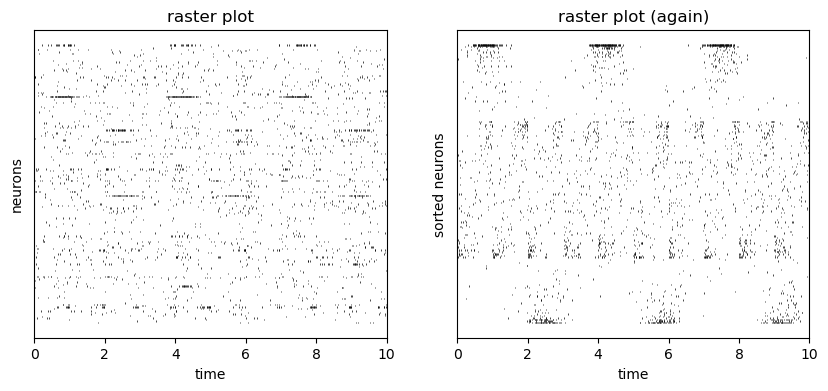

In [15]:
raster = []
rasterSorted = []
for k in range(nNeuron):
    raster.append(np.nonzero(y[k,:])[0]/nT*T)
    rasterSorted.append(np.nonzero(y[cidx[k],:])[0]/nT*T)

plt.subplots(1,2, figsize=(10, 4))
plt.subplot(1,2,1)
plt.eventplot(raster, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.title('raster plot'); plt.ylabel('neurons');
plt.subplot(1,2,2)
plt.eventplot(rasterSorted, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.yticks([]); plt.title('raster plot (again)'); plt.ylabel('sorted neurons');

## What's next?

Now we understand better the generative process of the model. But what we are interested is the opposite direction, that is, how do we infer the model parameters given just the observations (neural data)? This is the statistical inference problem of interest.